In [171]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sparse_shift.plotting import plot_dag
from collections import defaultdict
sns.set_context('notebook')

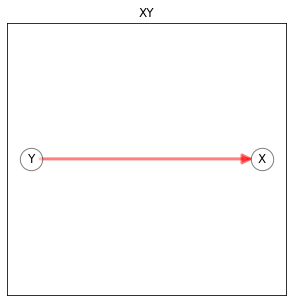

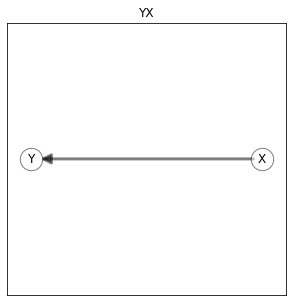

In [5]:
dag_dict = {
    'XY': np.asarray([[0, 1], [0, 0]]),
    'YX': np.asarray([[0, 0], [1, 0]])
}

true_parents = dag_dict['YX']

for key, dag in dag_dict.items():
    plot_dag(
        dag,
        highlight_edges=dag-true_parents,
        labels=['X', 'Y'],
        title=key)

In [156]:
def create_metrics_df(raw_df, true_dag_key='YX'):
    df = raw_df.copy()
    
    n_features = 1
    while f'X{n_features}' in df.columns:
        n_features += 1
    n_features -= 1

    alpha = 0.05 / n_features
    dag_keys = df['dag'].unique()

    # convert from pvalues to n_changes at alpha
    df['total_changes'] = 0
    for i in range(1, n_features+1):
        df[f'X{i}'] = df[f'X{i}'] <= alpha
        df['total_changes'] += df[f'X{i}']
    
    # group by everything except dag, and variables
    # +2 for reps and total_changes
    group_cols = list(df.columns[:-(n_features+2)]) 
    df = pd.pivot_table(df, index=group_cols,
        values='total_changes',
        columns='dag').reset_index()

    # within each rep, compute:
    # - min changes
    # - true dag in min set
    # - size of min set
    
    df['min_changes'] = df[dag_keys].min(1)
    df['true_in_min_set'] = df[true_dag_key] == df['min_changes']
    df['min_set_size'] = np.sum([df[key] == df['min_changes'] for key in dag_keys], 0)
    
    df['true_identified'] = df['true_in_min_set'] & (df['min_set_size'] == 1)
    df['false_identified'] = 1 - df['true_in_min_set']
    df['undetermined'] = df['true_in_min_set'] & (df['min_set_size'] > 1)
    
    return df.groupby(group_cols[:-1]).mean().reset_index()

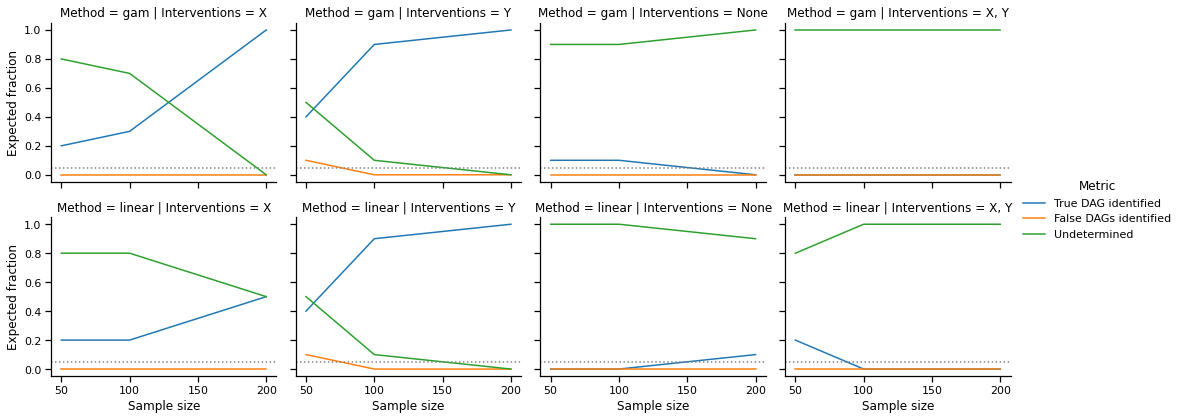

In [174]:
df = pd.read_csv('./bivariate_icp_pvalues_sample_size.csv', delimiter=', ', engine='python')
metrics_df = create_metrics_df(df, true_dag_key='YX')

plot_df = metrics_df.melt(
    id_vars=['params_index', 'test_kwargs', 'intervention_targets', 'n_samples'],
    value_vars=['true_identified', 'false_identified', 'undetermined'],
    var_name='metric',
    value_name='expected_fraction',
)

plot_df.replace(
    {
        "{'method': 'gam','test': 'ks'}": 'gam',
        "{'method': 'linear','test': 'ks'}": 'linear',
        "[None,0]": 'X',
        "[None,1]": 'Y',
        "[0,1]": 'X, Y',
        "[None,None]": 'None',
        "true_identified": "True DAG identified",
        "false_identified": "False DAGs identified",
        "undetermined": "Undetermined",
    }, inplace=True
)

plot_df.rename(
    {
        "test_kwargs": "Method",
        "n_samples": "Sample size",
        "expected_fraction": "Expected fraction",
        "intervention_targets": "Interventions",
        "metric": "Metric",
    }, axis=1, inplace=True
)

g = sns.relplot(
    data=plot_df,
    x='Sample size',
    y='Expected fraction',
    col='Interventions',
    row='Method',
    hue='Metric',
    kind='line',
    height=3, aspect=1.2,
    legend='full',
)

for ax in g.axes.flatten():
    ax.axhline(0.05, ls=':', c='grey')

# plt.savefit('./bivariate_')
plt.show()

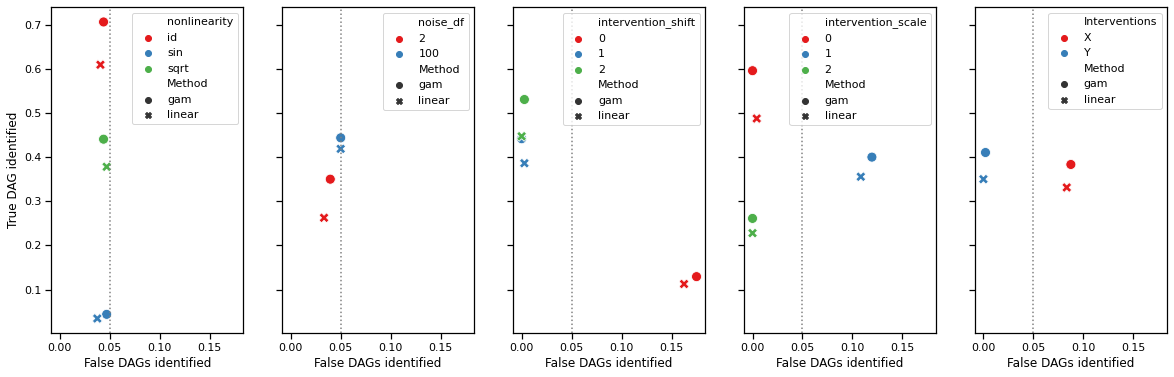

In [282]:
df = pd.read_csv('./bivariate_icp_pvalues.csv', delimiter=', ', engine='python')
metrics_df = create_metrics_df(df, true_dag_key='YX')

grid_vars = ['nonlinearity', 'noise_df', 'intervention_shift', 'intervention_scale']

# plot_df = metrics_df.melt(
#     id_vars=grid_vars + ['test_kwargs', 'intervention_targets', 'n_samples'],
#     value_vars=['true_identified', 'false_identified', 'undetermined'],
#     var_name='metric',
#     value_name='expected_fraction',
# )

plot_df = metrics_df

plot_df.replace(
    {
        "{'method': 'gam','test': 'ks'}": 'gam',
        "{'method': 'linear','test': 'ks'}": 'linear',
        "[None,0]": 'X',
        "[None,1]": 'Y',
        "[0,1]": 'X, Y',
        "[None,None]": 'None',

    }, inplace=True
)

plot_df.rename(
    {
        "test_kwargs": "Method",
        "n_samples": "Sample size",
        "expected_fraction": "Expected fraction",
        "intervention_targets": "Interventions",
        "metric": "Metric",
        "true_identified": "True DAG identified",
        "false_identified": "False DAGs identified",
        "undetermined": "Undetermined",
    }, axis=1, inplace=True
)

x_var = 'False DAGs identified' # 'Interventions'
y_var = 'True DAG identified'

grid_vars = ['nonlinearity', 'noise_df', 'intervention_shift', 'intervention_scale', 'Interventions']

fig, axes = plt.subplots(1, 5, sharey=True, sharex=True, figsize=(20, 6))

for g_var, ax in zip(grid_vars, axes.flatten()):
    sns.scatterplot(
        # [plot_df['Method'] == 'gam']
        data=plot_df.groupby([g_var, 'Method']).mean().reset_index(),
        x=x_var,
        y=y_var,
        hue=g_var,
        style="Method",
        ax=ax,
        # markers=['d', 'P', 's'],
        palette='Set1',
        legend='full',
        # alpha=1,
        s=100
    )
    
    ax.axvline(0.05, ls=':', c='grey')
    # ax.set_title('')
    ax.legend(loc='upper right')

plt.show()